## Данные

Датасет состоит из ~20000 изображений. Изображения находящиеся в папке “0” - допустимые. В папке “1” - фродовые.



In [ ]:
# Code for data download
!wget https://ml.gan4x4.ru/wb/text/75_20000/student.zip

#!wget -O student.zip "https://www.dropbox.com/scl/fi/mnuwscxw4razhqqxsizxf/LittleDataset.zip?rlkey=w72f29dp4cygap0k115xo68rs&st=2dhzca8z&dl=0"
!unzip student.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: student/0/165549915.jpg  
  inflating: student/0/168140935.jpg  
  inflating: student/0/138750805.jpg  
  inflating: student/0/167949858.jpg  
  inflating: student/0/138640702.jpg  
  inflating: student/0/134580396.jpg  
  inflating: student/0/166891740.jpg  
  inflating: student/0/144942407.jpg  
  inflating: student/0/167163464.jpg  
  inflating: student/0/165713620.jpg  
  inflating: student/0/124272811.jpg  
  inflating: student/0/127734193.jpg  
  inflating: student/0/165069600.jpg  
  inflating: student/0/168155894.jpg  
  inflating: student/0/134343645.jpg  
  inflating: student/0/166176778.jpg  
  inflating: student/0/165321187.jpg  
  inflating: student/0/168748850.jpg  
  inflating: student/0/161742620.jpg  
  inflating: student/0/128201372.jpg  
  inflating: student/0/140053769.jpg  
  inflating: student/0/168062748.jpg  
  inflating: student/0/165838367.jpg  
  inflating: student/0/161385657.jp

# Анализ данных

In [ ]:
import os
import matplotlib.pyplot as plt
import random

In [ ]:
dataPath_1 = '/content/student/1'
dataPath_0 = '/content/student/0'

In [ ]:
dataPathTest_1 ='/content/test/1'
dataPathTest_0 = '/content/test/0'
anotation_PathTest ='/content/test/anotation.csv'

In [ ]:
fraudImg = list(os.listdir(dataPath_1))
okImg = list(os.listdir(dataPath_0))

random.shuffle(fraudImg)
random.shuffle(okImg)

In [ ]:
fraudImgPath = [dataPath_1 + '/' + img for img in fraudImg]
okImgPath = [dataPath_0  + '/' + img for img in okImg]

Всего изображений 19808


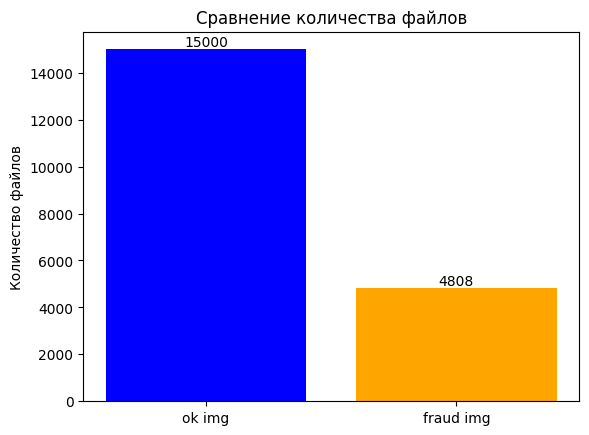

In [ ]:
labels = ['ok img', 'fraud img']
values = [len(okImg), len(fraudImg)]

# Создание фигуры и осей
fig, ax = plt.subplots()

# Построение столбчатой диаграммы
bars = ax.bar(labels, values, color=['blue', 'orange'])

# Добавление заголовка и меток осей
ax.set_title('Сравнение количества файлов')
ax.set_ylabel('Количество файлов')

# Добавление значений над столбцами
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, yval, ha='center', va='bottom')

# Показ диаграммы
print(f"Всего изображений {sum(values)}")
plt.show()

In [ ]:
import pandas as pd

# Создаем DataFrame для фрод-изображений
fraud_data = pd.DataFrame({
    'name': fraudImgPath,
    'fraud': [1] * len(fraudImg),  # Все значения fraud равны 1
    'text': [''] * len(fraudImg)    # Пустое поле text
})

# Создаем DataFrame для нормальных изображений
ok_data = pd.DataFrame({
    'name': okImgPath,
    'fraud': [0] * len(okImg),      # Все значения fraud равны 0
    'text': [''] * len(okImg)        # Пустое поле text
})

# Объединяем два DataFrame
dataDf = pd.concat([fraud_data, ok_data], ignore_index=True)
dataDf = dataDf.sample(frac=1).reset_index(drop=True)
dataDf.head(5)

name  fraud text
0  /content/student/0/168238760.jpg      0     
1  /content/student/0/167597603.jpg      0     
2  /content/student/0/157846121.jpg      0     
3  /content/student/1/150913953.jpg      1     
4  /content/student/1/168984041.jpg      1

# Тренировка и инициализация моделей

## считывание текста с датасета

### easyocr (считывание в датасет)

In [ ]:
!pip install python-bidi==0.4.2 --quiet
!pip install easyocr --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 53.7 MB/s eta 0:00:00


In [ ]:
import re
import easyocr
import cv2
import numpy as np
from PIL import Image
import io

In [ ]:
# Функция для объединения строк
def merge_strings(s1, s2):
    merged = []
    for part1, part2 in zip(s1, s2):
        # Находим индекс первого английского символа или знака @
        match = re.search(r'[a-zA-Z@]', part1)
        if match:
            # Получаем индекс первого вхождения
            index = match.start()
            # Составляем новую строку: часть до английского символа + часть из второй строки
            new_part = part1[:index] + part2[index:]  # Заменяем только часть начиная с первого английского символа
            merged.append(new_part)
        else:
            merged.append(part1)  # Если английских символов нет, оставляем часть из первой строки
    return merged

def norm_string(s1):
    merged = []
    for part in s1:
          merged.append(part)
    return merged

In [ ]:
def clean_text(text):
    # Переводим текст в нижний регистр
    text = text.lower()

    # Заменяем знак ₽ на "р"
    text = text.replace("₽", "р")

    # Заменяем "o" и "о" на "0", если слева стоит цифра
    text = re.sub(r'(?<=\d)(o|о)', '0', text)

    # Удаляем все знаки препинания, кроме пробелов и тире
    text = re.sub(r'[^\w\s-]', '', text)

    return text

def remove_short_words(text):
  # Разделяем текст на слова
  words = text.split()

  # Фильтруем слова
  filtered_words = [
      word for word in words
      if len(word) >= 3 or re.search(r'\d', word)  # Сохраняем слово, если оно длиннее 2 символов или содержит цифры
  ]

  # Объединяем отфильтрованные слова обратно в строку
  return ' '.join(filtered_words)

In [ ]:
class TextRecognizer:
    def __init__(self, languages=["ru", "en"]):
        # Инициализация модели только один раз
        self.reader = easyocr.Reader(languages)

    def text_recognition(self, file_path):
        # Предобработка изображения
        img = imgPreproces(file_path)
        result_base = ""
        result_base += self.recognition(img) + "\n"
        result_base += self.recognition(img,spin=True)

        tmp = clean_text(result_base)
        return tmp

    def recognition(self,img, spin = False):
        if spin:
          spinList = [90,270]
        else: spinList = None

        # Чтение текста с изображения
        res = self.reader.readtext(
            img,
            decoder='wordbeamsearch',
            detail=0,
            paragraph=True,
            batch_size=64,
            rotation_info = spinList
        )
        result = norm_string(res)
        # Преобразуем результат в строку
        final_result = ' '.join(result)
        return final_result



In [ ]:
def imgPreproces(file_path):
    image = cv2.imread(file_path,0)
    return image

    average_brightness = int(np.mean(image))
    if (average_brightness > 110):
      invert = cv2.bitwise_not(image)
    else: invert = image

    brightnes = cv2.convertScaleAbs(invert, beta=60)

    _, im_bw = cv2.threshold(brightnes, 200, 230, cv2.THRESH_BINARY)

    return im_bw

In [ ]:
if(1):
  recognizer = TextRecognizer()
  file_path = '/content/test/1/img (1).jpg'#"/content/LittleDataset/1/" + "168089159.jpg"

  res = recognizer.text_recognition(file_path)
  print(res)

i1  7 е f
сэоbвы  rich плачу тг




---



### Исправление текста

In [ ]:
!pip install errant --quiet
!pip install Levenshtein --quiet
!pip install transformers --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.3/499.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 4.6 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/ai-forever/sage.git

Cloning into 'sage'...
remote: Enumerating objects: 582, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 582 (delta 109), reused 139 (delta 63), pack-reused 347
Receiving objects: 100% (582/582), 16.25 MiB | 16.68 MiB/s, done.
Resolving deltas: 100% (299/299), done.


In [ ]:
!pip install /content/sage/. --quiet

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.5.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have py

In [ ]:
from sage.spelling_correction import AvailableCorrectors
from sage.spelling_correction import RuM2M100ModelForSpellingCorrection, T5ModelForSpellingCorruption

def text_corrector(text):
  corrector_small = T5ModelForSpellingCorruption.from_pretrained(AvailableCorrectors.sage_fredt5_distilled_95m.value) #sage - fredt5_distilled_95m

  #corrector_medium = RuM2M100ModelForSpellingCorrection.from_pretrained(AvailableCorrectors.sage_m2m100_1B.value) # sage_m2m100_1B
  #corrector_big = T5ModelForSpellingCorruption.from_pretrained(AvailableCorrectors.sage_mt5_large.value) #sage - fredt5_large
  #del corrector_big.model

  res = str(corrector_small.correct(text))
  res = res.translate(str.maketrans("", "", "[]'"))
  return res



AttributeError: module 'pyarrow.lib' has no attribute 'ListViewType'

In [ ]:
#del corrector_small.model
#del corrector_medium.model
#del corrector_big.model

In [ ]:
text_ru = "заподобные отзовы мышпиденыи 10 зызов -100р подйнепивт uыw_ыыlп"
print(text_corrector(text_ru))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/789 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/383M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.3k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.72k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/1 [00:00<?, ?it/s]

Заподобные отзывы: мышпидены, 10 отзывов - 100 р. поднепивут uaw_ыыlп.


### считывание датасета

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
#fraudImg = list(os.listdir(dataPath_1))
#okImg = list(os.listdir(dataPath_0))
data = []
recognizer = TextRecognizer()

for img in tqdm(fraudImg[:1000]):
  res = recognizer.text_recognition(dataPath_1+"/"+img)
  data.append((res, img))

# Создаем DataFrame из списка данных
dfFraudTxt = pd.DataFrame(data, columns=['text','img'])
dfFraudTxt['label'] = 1

dfFraudTxt.to_csv('dfFraudTxt.csv', index=False)
dfFraudTxt

  0%|          | 0/1000 [00:00<?, ?it/s]

text            img  label
0    зарабатывай от 3000 в день на отзывах подойдет...  148101990.jpg      1
1    за maкue оmзывы namяm 25 wmук 3000 p рi  ш 8  ...  130354321.jpg      1
2    за такие отзывы реально платят зооор 30 шт тел...  128479262.jpg      1
3    прикольно затакие кommeнтaрuu платятот 2500p в...  124740336.jpg      1
4    за такие отзывы платят зошт-250ор ищибот в т0 ...  143158041.jpg      1
..                                                 ...            ...    ...
995  зарабатывай от 3000 в день на отзывах ищи кана...  141223652.jpg      1
996  ребята кому нужна подработка просто пиши отзыв...  153335008.jpg      1
997  привем uckaла иленно чебя приzлашаю мебя haw к...  128054831.jpg      1
998  ребятки кому нужна подроботка нужно делать про...  155390477.jpg      1
999  деныги за отзывы зооор за зофт лиwи в тu team ...  129845315.jpg      1

[1000 rows x 3 columns]

In [ ]:
data = []
recognizer = TextRecognizer()

for img in tqdm(okImg[:1000]):
  res = recognizer.text_recognition(dataPath_0+"/"+img)
  data.append((res, img))

# Создаем DataFrame из списка данных
dfOkTxt = pd.DataFrame(data, columns=['text','img'])
dfOkTxt['label'] = 0

dfOkTxt.to_csv('dfOkTxt.csv', index=False)
dfOkTxt

  0%|          | 0/1000 [00:00<?, ?it/s]

text            img  label
0                                                   \n  165457175.jpg      1
1                                                 2 \n  165062234.jpg      1
2                                                   \n  166755105.jpg      1
3                                                   \n  149660260.jpg      1
4                                                   \n  130183329.jpg      1
..                                                 ...            ...    ...
995  balszzrougl wякsпь dedy с exeehvdom qiowouq\n1...  166439751.jpg      1
996                                                 \n  145510667.jpg      1
997  ketoni с   форть усиланная  актнвное mо вв mco...  166542458.jpg      1
998                                                 \n  169532015.jpg      1
999  vur кедровс drganic pin сачami келровые  wиа п...  166697929.jpg      1

[1000 rows x 3 columns]

In [ ]:
dfText = pd.concat([dfFraudTxt, dfOkTxt], ignore_index=True)
dfText.to_csv('dfText.csv', index=False)
dfText

text            img  label
0     зарабатывай от 3000 в день на отзывах подойдет...  148101990.jpg      1
1     за maкue оmзывы namяm 25 wmук 3000 p рi  ш 8  ...  130354321.jpg      1
2     за такие отзывы реально платят зооор 30 шт тел...  128479262.jpg      1
3     прикольно затакие кommeнтaрuu платятот 2500p в...  124740336.jpg      1
4     за такие отзывы платят зошт-250ор ищибот в т0 ...  143158041.jpg      1
...                                                 ...            ...    ...
1995  balszzrougl wякsпь dedy с exeehvdom qiowouq\n1...  166439751.jpg      0
1996                                                 \n  145510667.jpg      0
1997  ketoni с   форть усиланная  актнвное mо вв mco...  166542458.jpg      0
1998                                                 \n  169532015.jpg      0
1999  vur кедровс drganic pin сачami келровые  wиа п...  166697929.jpg      0

[2000 rows x 3 columns]

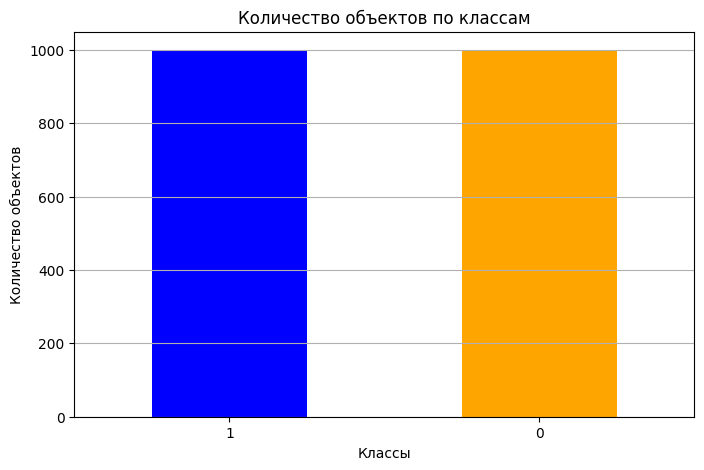

In [ ]:
label_counts = dfText['label'].value_counts()

# Построение графика
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Количество объектов по классам')
plt.xlabel('Классы')
plt.ylabel('Количество объектов')
plt.xticks(rotation=0)  # Поворот меток по оси X
plt.grid(axis='y')
plt.show()

In [ ]:
#sound_alert()

## Текст с картинки

### easyocr

In [ ]:
!pip install python-bidi==0.4.2 --quiet
!pip install easyocr --quiet

  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 3.0 MB/s eta 0:00:00
Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 52.0 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.2.0
    Uninstalling triton-2.2.0:
      Successfully uninstalled triton-2.2.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.19.3
    Uninstalling nvidia-nccl-cu12-2.19.3:
      Successfully uninstalled nvidia-nccl-cu12-2.19.3
  Attempting uninstall: torch
    Found existing installation: torch 2.2.0
    Un

In [ ]:
from IPython.display import Image, display

In [ ]:
import re
# Функция для объединения строк
def merge_strings(s1, s2):
    merged = []
    for part1, part2 in zip(s1, s2):
        # Находим индекс первого английского символа или знака @
        match = re.search(r'[a-zA-Z@]', part1)
        if match:
            # Получаем индекс первого вхождения
            index = match.start()
            # Составляем новую строку: часть до английского символа + часть из второй строки
            new_part = part1[:index] + part2[index:]  # Заменяем только часть начиная с первого английского символа
            merged.append(new_part)
        else:
            merged.append(part1)  # Если английских символов нет, оставляем часть из первой строки
    return merged

def norm_string(s1):
    merged = []
    for part in s1:
          merged.append(part)
    return merged

In [ ]:
import re

def clean_text(text):
    # Переводим текст в нижний регистр
    text = text.lower()

    # Заменяем знак ₽ на "р"
    text = text.replace("₽", "р")

    # Заменяем "o" и "о" на "0", если слева стоит цифра
    text = re.sub(r'(?<=\d)(o|о)', '0', text)

    # Удаляем все знаки препинания, кроме пробелов и тире
    text = re.sub(r'[^\w\s-]', '', text)

    return text

In [ ]:
import easyocr
import cv2

def text_recognition(file_path):
    #img preproces
    img = imgPreproces(file_path)

    reader = easyocr.Reader(["ru","en"])
    result_rus = reader.readtext(img,
                                 decoder = 'wordbeamsearch',
                                 detail=0,
                                 paragraph=True,
                                 batch_size = 8
                                 #rotation_info = [90,180,270] # добавить отдельный вывод с поворотами

                                 )
    '''
    reader = easyocr.Reader(["en"])
    result_eng = reader.readtext(img,
                                 detail=0,
                                 paragraph=True,
                                 batch_size = 2
                                 )
    '''

    #print("ru,en: ", result_rus)
    #print("en: ", result_eng)
    # Объединяем строки
    result = norm_string(result_rus) #merge_strings(result_rus, result_eng)
    # Преобразуем результат в строку
    final_result = ' '.join(result)
    tmp = clean_text(final_result)
    return tmp

In [ ]:
import cv2
import numpy as np
from PIL import Image
import io

def imgPreproces(file_path):
    image = cv2.imread(file_path,0)

    average_brightness = int(np.mean(image))
    if (average_brightness > 110):
      invert = cv2.bitwise_not(image)
    else: invert = image

    brightnes = cv2.convertScaleAbs(invert, beta=60)

    _, im_bw = cv2.threshold(brightnes, 200, 230, cv2.THRESH_BINARY)

    return im_bw

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
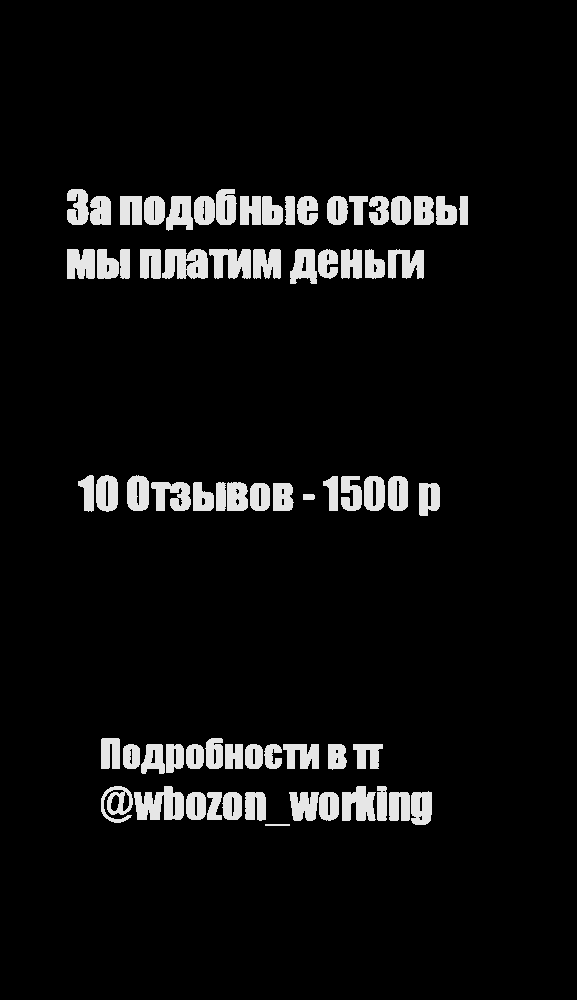

заподобные отзовы мышhпиденыи 10 зызов -100р подйнепивт uыw_ыыlп


In [ ]:
file_path = "/content/LittleDataset/1/123307903.jpg"


display(imgPreproces(file_path))

print(text_recognition(file_path))

/content/LittleDataset/1/151613182.jpg
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete
 Ребятки; кому нужна подроботка? Нужно делать просто скрины 20 скринов 1250 30 скринов 18оо 40 скринов - 2490 50 скринов < б10о От вас нет никаких вложений) подойдёт любой возраст! Писать в T1 'zadimic_vsem_bot.


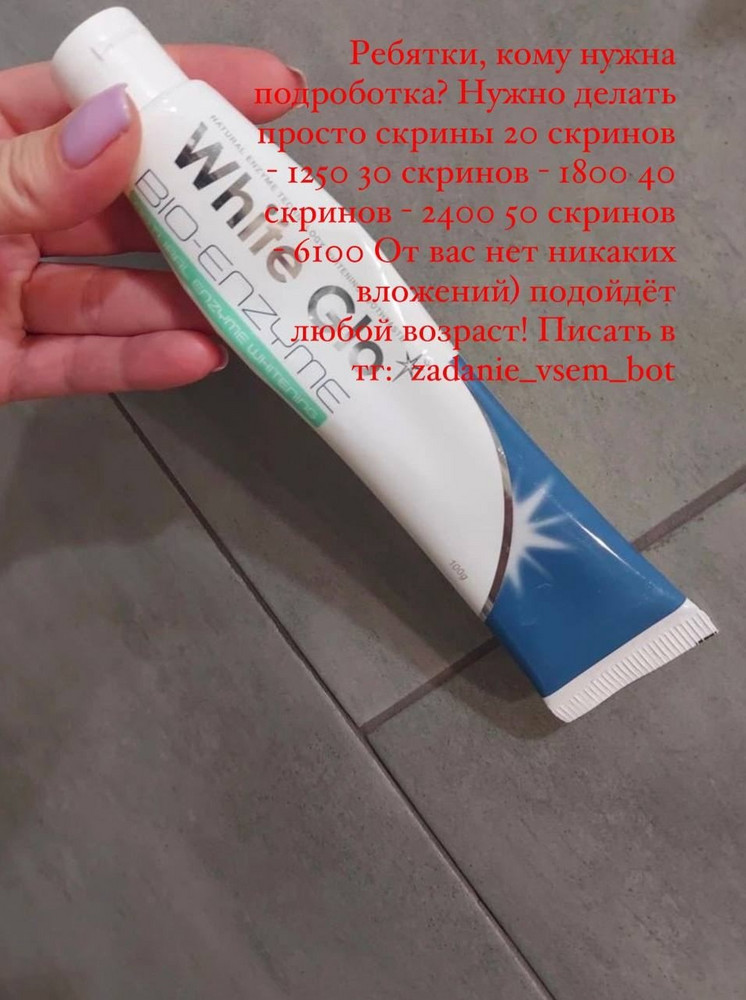


-----------

/content/LittleDataset/1/123147252.jpg

 # 7 4; Получите хорошую возможность зарабатывать деньги за отзывы на Wildberries 25ООР-за 30 отзывов Подробнее в телеграмм: @vasilisa_rabota


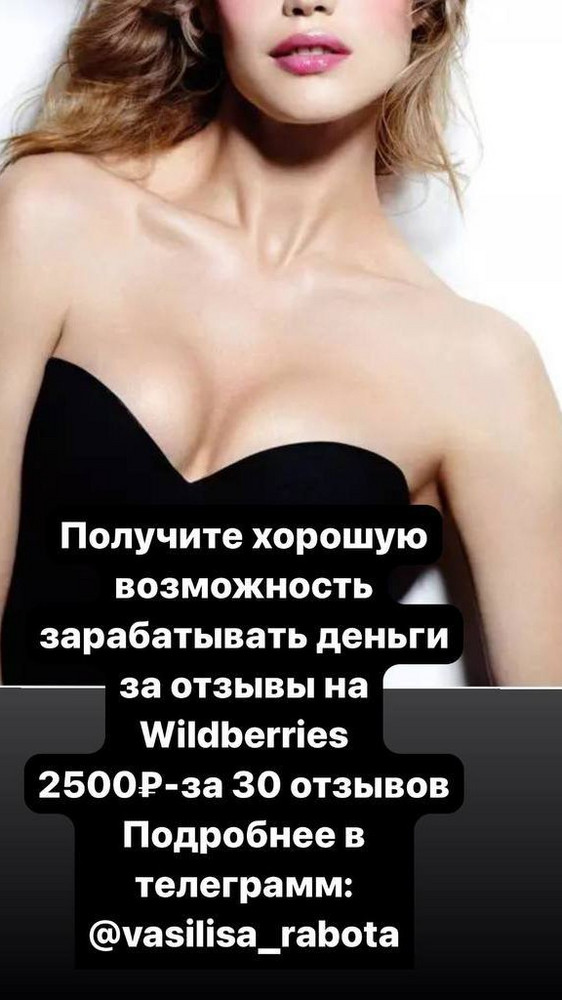


-----------

/content/LittleDataset/1/142151983.jpg

 Затакие ОТЗЫВЫ ПЛаТят 2500P за25 шТ Ищибот: otzovy_work_wb_bot


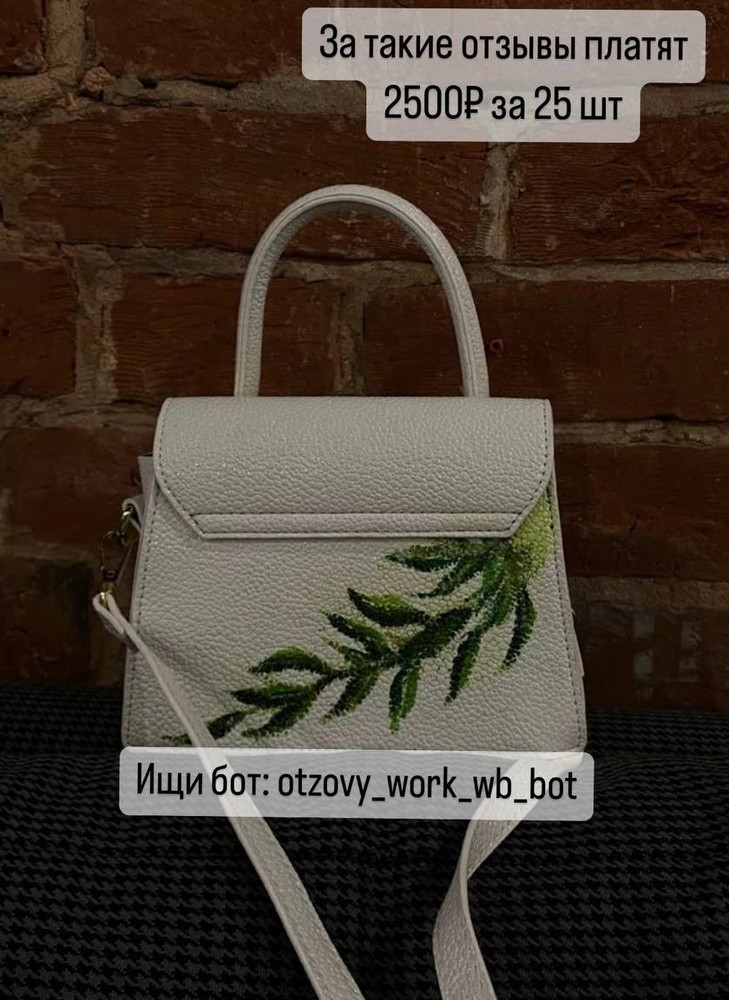


-----------

/content/LittleDataset/1/142044076.jpg

 


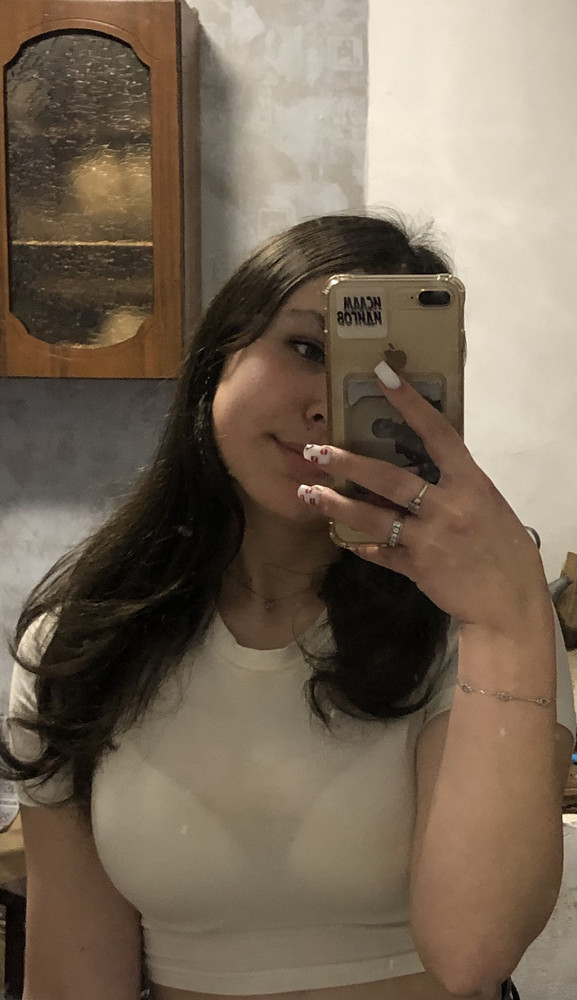


-----------

/content/LittleDataset/1/123495634.jpg

 Анд Аым#r 25wwg; Див лк {Кы ({r' 'Jkц . #спаж ще5 дкд 31: 9 % ё I6}ki фл 55:4 #; Vix<iit - 4f;' Чыuu4ъ ;] v  f Йыщин иiz ц #aWп Сасяшу ;; : = #би67 нn 73 4 '' ; #4gg04.еu {4i4- Тыч иЁm #Sре 4и2! &триу янCKu '₽4 Фркыzi {чж# #и"i Датз аожлення #ыялика - {#шрящ; 'Bu Ппhчн-плынл шеты Илодэна2 &*. 3{1х . _ яI f


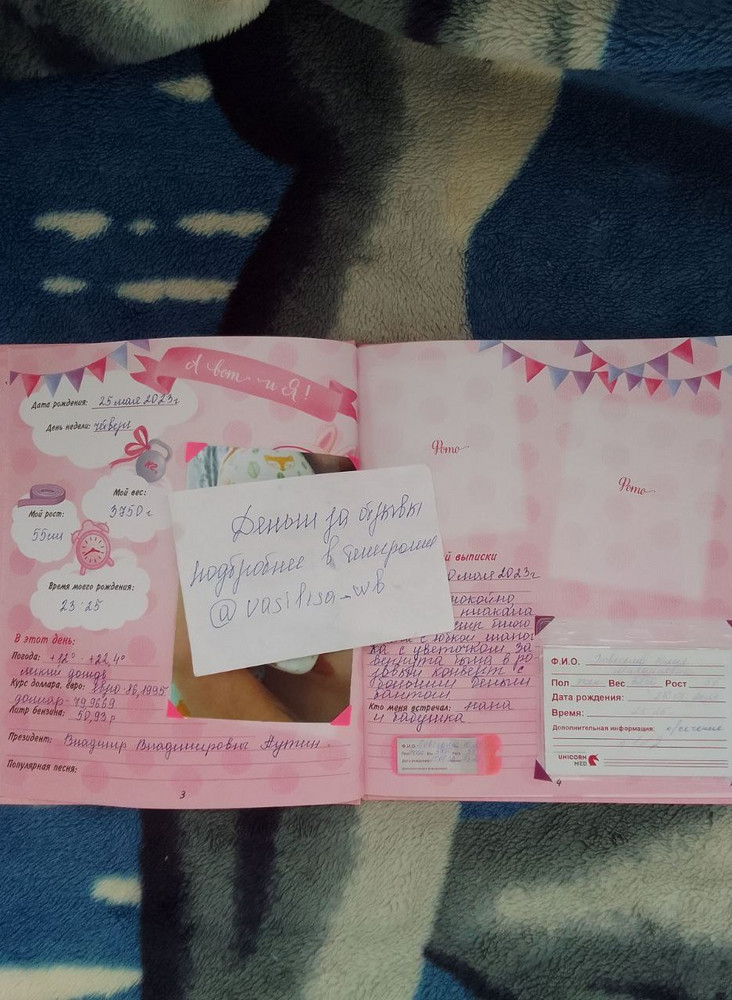


-----------

/content/LittleDataset/1/142148235.jpg

 За такие отзывы платят реальные деньги: 25 шт ЗОООр Ищи телегу: anteam_wb NAGARAKU LIFT PADS 5m 5ml NAC;ARAKU 5m] Sml


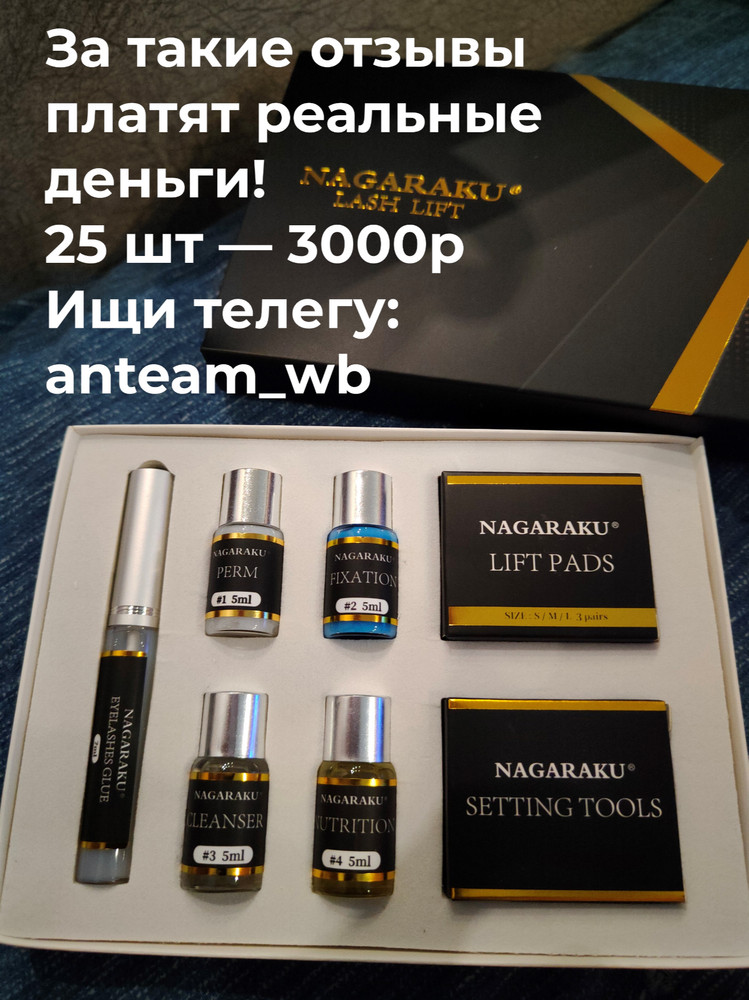


-----------

/content/LittleDataset/1/142214385.jpg

 Затакие ОТЗЫВЫ пЛаТЯТ 2500Pза25 шТ Ищи бот: otzowy_work_wb_bot


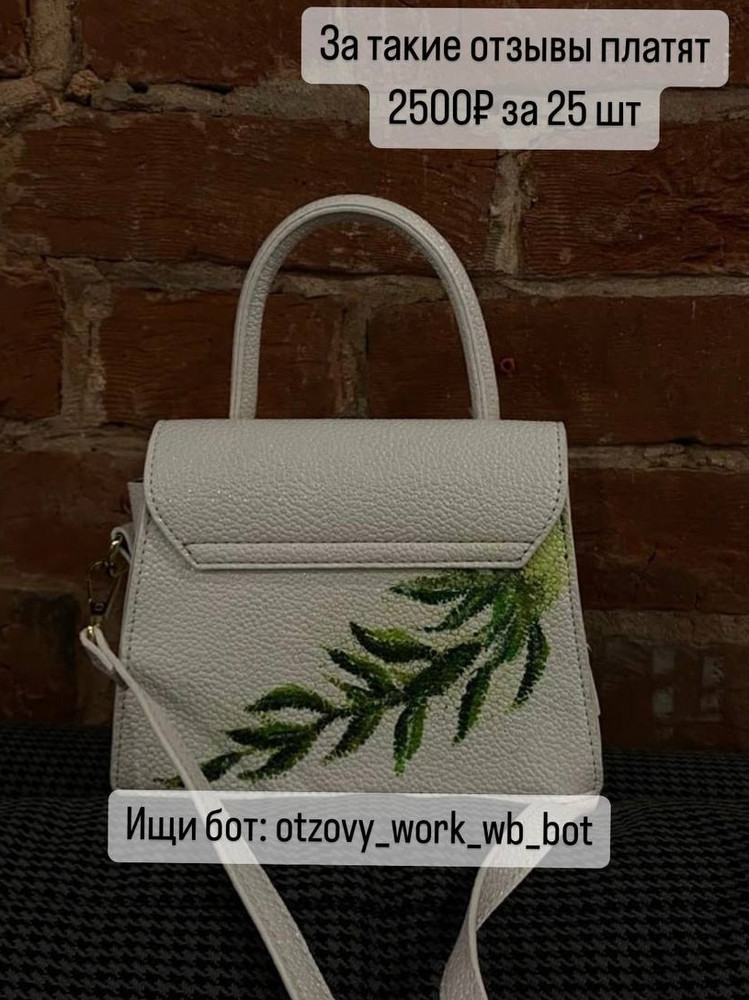


-----------

/content/LittleDataset/1/151619048.jpg

 WнiЁi{*fle 'LA SHIQQON F #OW WiAS@Ai  ИЩИ 0:


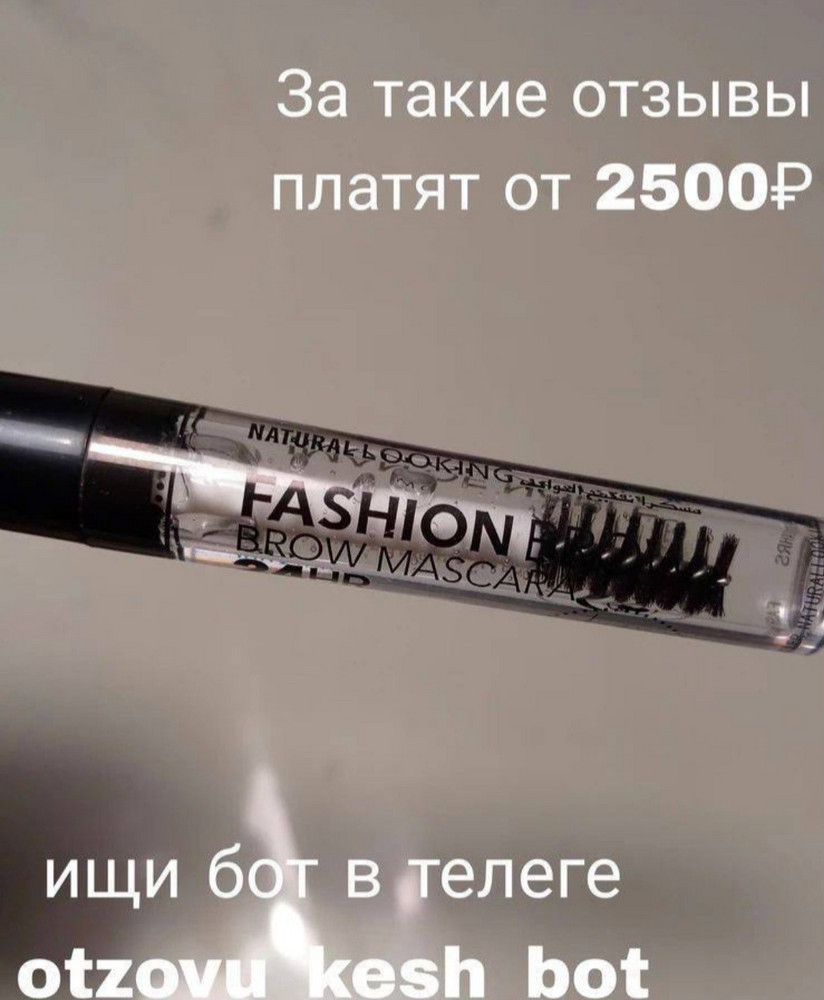


-----------

/content/LittleDataset/1/123307897.jpg

 Получайте хорошую возможность зарабатывать деньги за отзывы на Wildberries ЗОООр- за 30 отзывов Подробнее в телеграмм: princess_signal


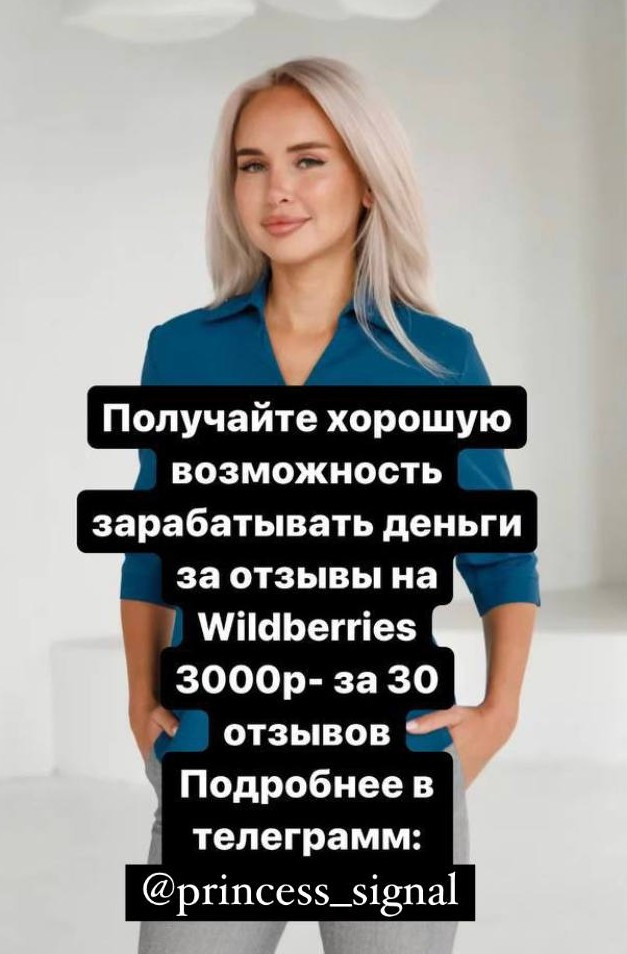


-----------

/content/LittleDataset/1/151637936.jpg

 оvшии ЮщИЕ Ребятки; кому нужна подработка? Нужно делать просто скрины! 15 скринов 1500 30 скринов 3000 50 скринов 6000 100 скринов - 12000 От вас нет никаких вложений! Ищи нас в телеграмме: @anast_wbozn ю 'a ножницы шлниа wi мъ WB OZON


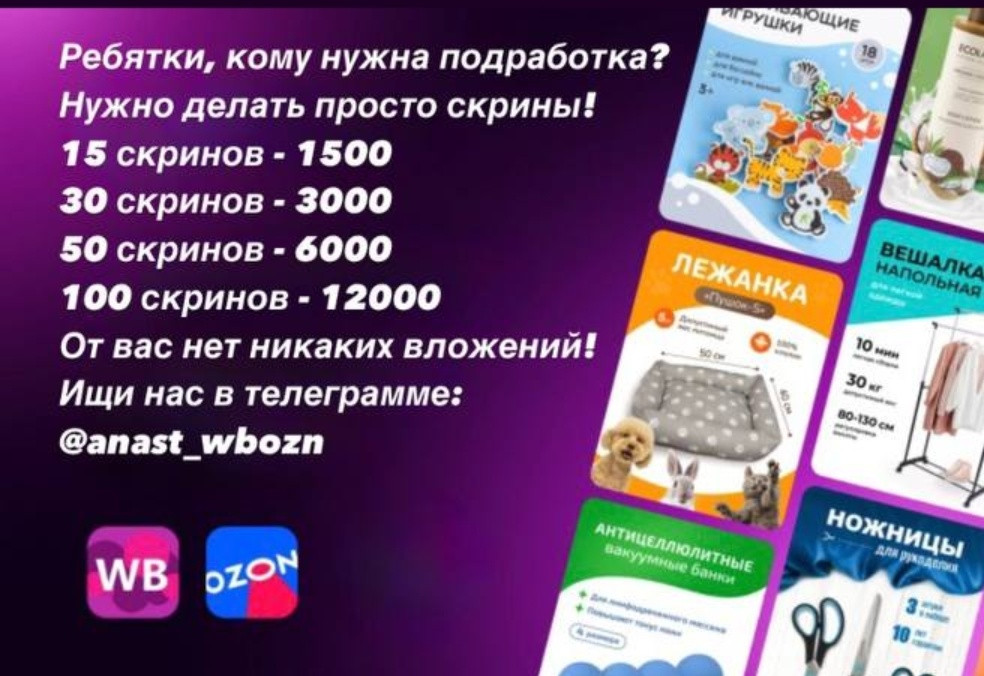


-----------



In [ ]:
from IPython.display import Image, display

for i in range(10):
  imgPath = dataPath_1+'/'+fraudImg[i]
  print(imgPath)
  print("\n",text_recognition(file_path=imgPath))
  img = Image(filename=imgPath, width=300)
  display(img)
  print("\n-----------\n")

### Paddle ocr

In [ ]:
!pip install paddlepaddle-gpu --quiet

In [ ]:
# Install paddle OCR
!pip install "paddleocr>=2.0.1"

In [ ]:
from paddleocr import PaddleOCR, draw_ocr # main OCR dependencies
from matplotlib import pyplot as plt # plot images
import cv2 #opencv
import os

In [ ]:
ocr_model = PaddleOCR(lang='ru')

[2024/07/23 18:54:59] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ml/Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/cyrillic/cyrillic_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

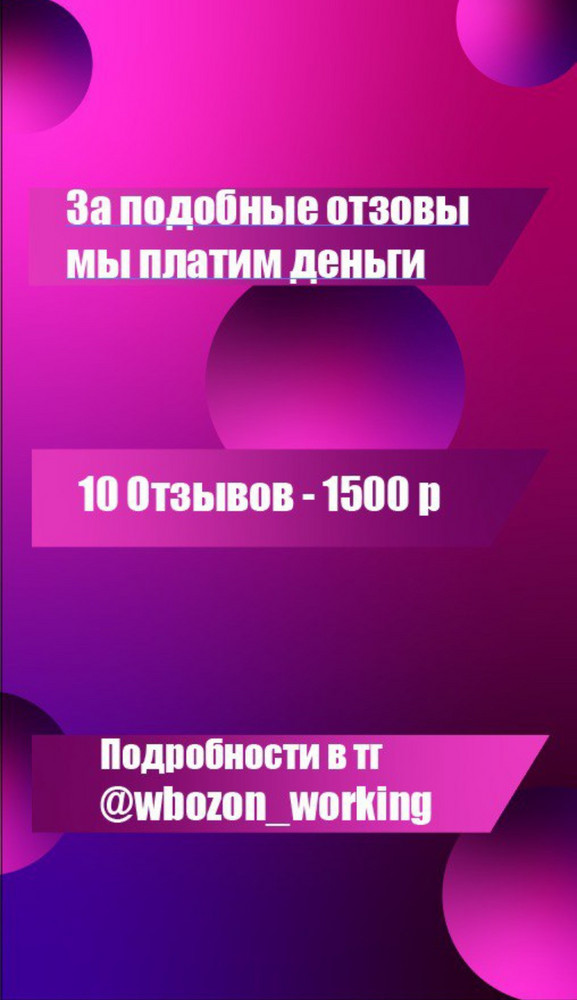

In [ ]:
from IPython.display import Image, display

img_path = "/content/LittleDataset/1/123307903.jpg"
img = Image(filename=img_path, width=300)
display(img)

In [ ]:
def paddle_predict(data_path):
  result = ocr_model.ocr(data_path, cls=True)
  word = ''
  for idx in range(len(result)):
      res = result[idx]
      if res != None:
        for line in res:
            word += str(line[1][0])+' '
  return word

/content/LittleDataset/1/151613182.jpg
[2024/07/23 19:11:05] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/07/23 19:11:05] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.07482290267944336
[2024/07/23 19:11:05] ppocr DEBUG: rec_res num  : 34, elapsed : 0.07814264297485352

 Ребятки кOму нужна подpоботка? укно целат просто скрины з скринов ђо з оо скринов о скринов д о скринов Gооо т Baс ет икаих вложений подойдёт любой BO3pacT! исатђ B Tr Zadanie Vsem. оt 


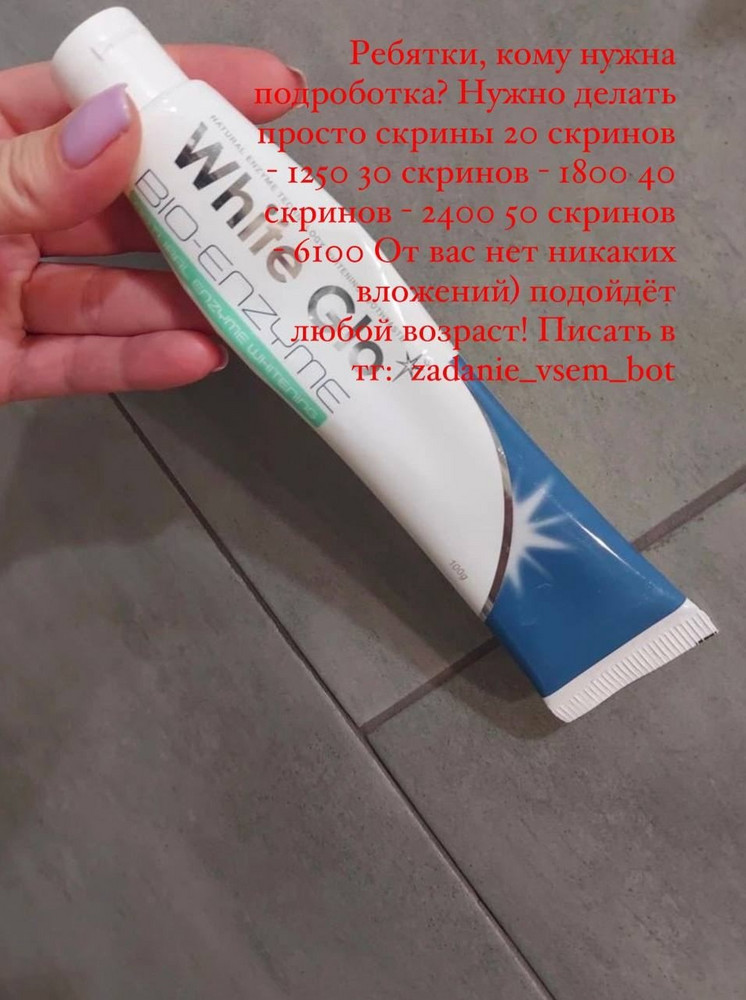


-----------

/content/LittleDataset/1/123147252.jpg
[2024/07/23 19:11:05] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/07/23 19:11:05] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.06331110000610352
[2024/07/23 19:11:05] ppocr DEBUG: rec_res num  : 16, elapsed : 0.05562925338745117

 олучите хорошую BOзмOжHOты зарабатывать деньги за отзђвь Hа Wildberries 25оор-3а 3о отзывов одробнее B телеграмм Ovasilisa.rabota 


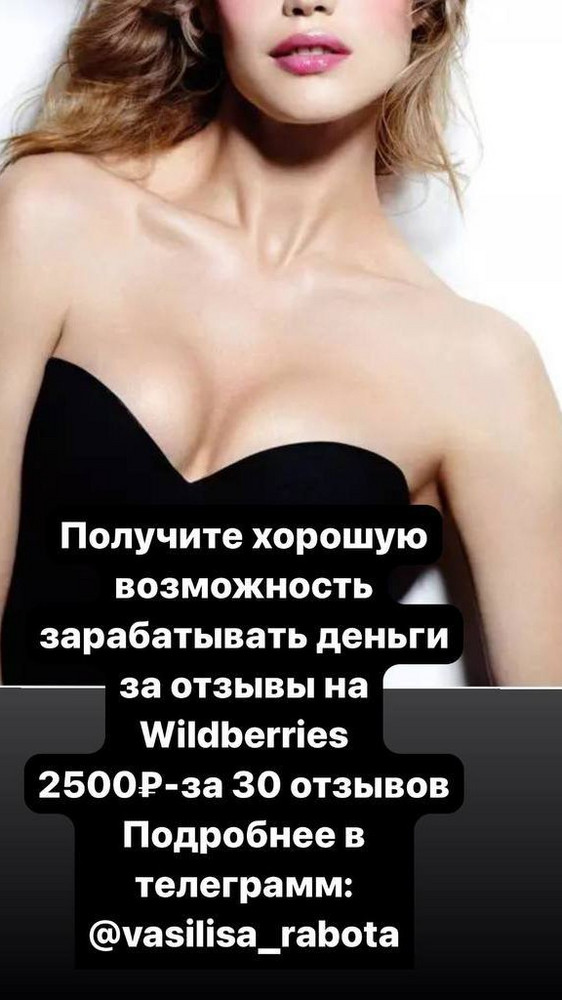


-----------

/content/LittleDataset/1/142151983.jpg
[2024/07/23 19:11:05] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/07/23 19:11:06] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.06064915657043457
[2024/07/23 19:11:06] ppocr DEBUG: rec_res num  : 13, elapsed : 0.03813314437866211

 а такие OтзbIBbI лата 25OOР за 25 шТ Иши бOT: OtzоVy Work. Wb_ bot 


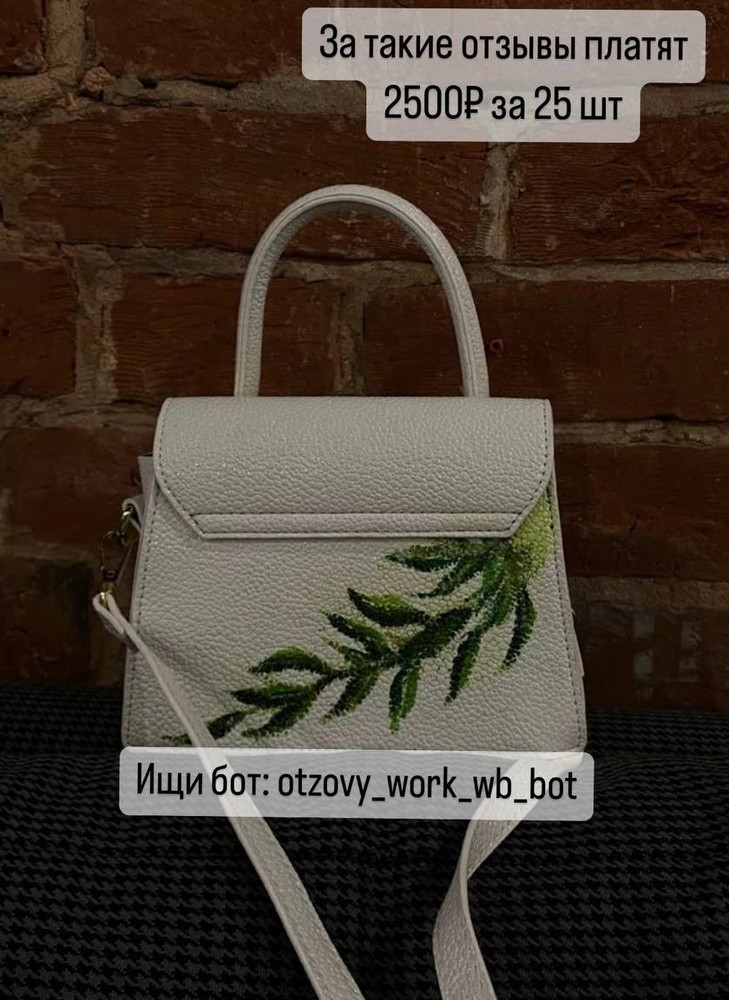


-----------

/content/LittleDataset/1/142044076.jpg
[2024/07/23 19:11:06] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/07/23 19:11:06] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.043016910552978516
[2024/07/23 19:11:06] ppocr DEBUG: rec_res num  : 1, elapsed : 0.008485794067382812

 


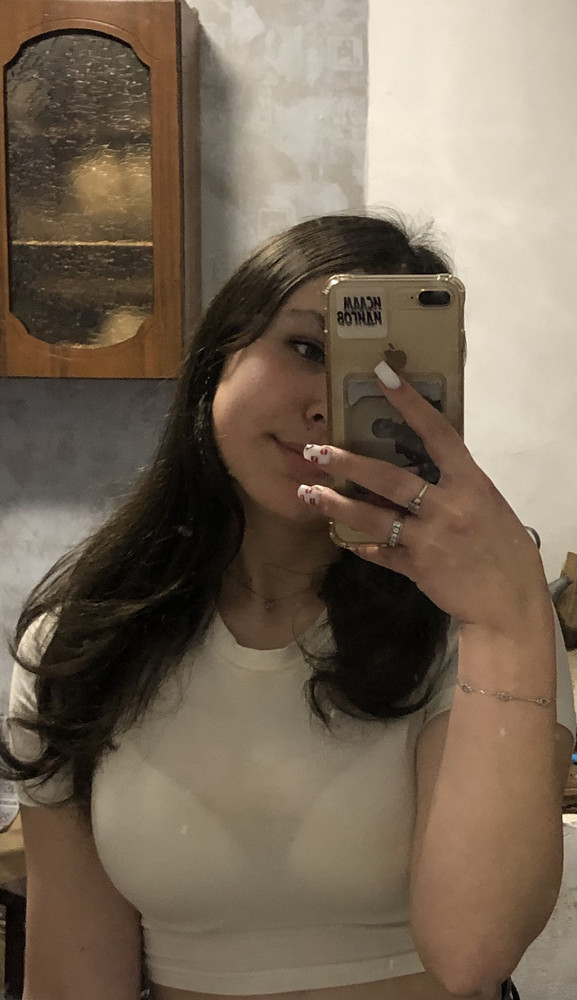


-----------

/content/LittleDataset/1/123495634.jpg
[2024/07/23 19:11:06] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/07/23 19:11:06] ppocr DEBUG: dt_boxes num : 80, elapsed : 0.09499812126159668
[2024/07/23 19:11:06] ppocr DEBUG: rec_res num  : 80, elapsed : 0.180619478225708

 г Tt t fuudhu. r Tiat gre! с мi T ийрй g roh? рий дэгs udg б .w. иирт Itaad йнг и инлдй Epan бдлир би Sаийрэ 


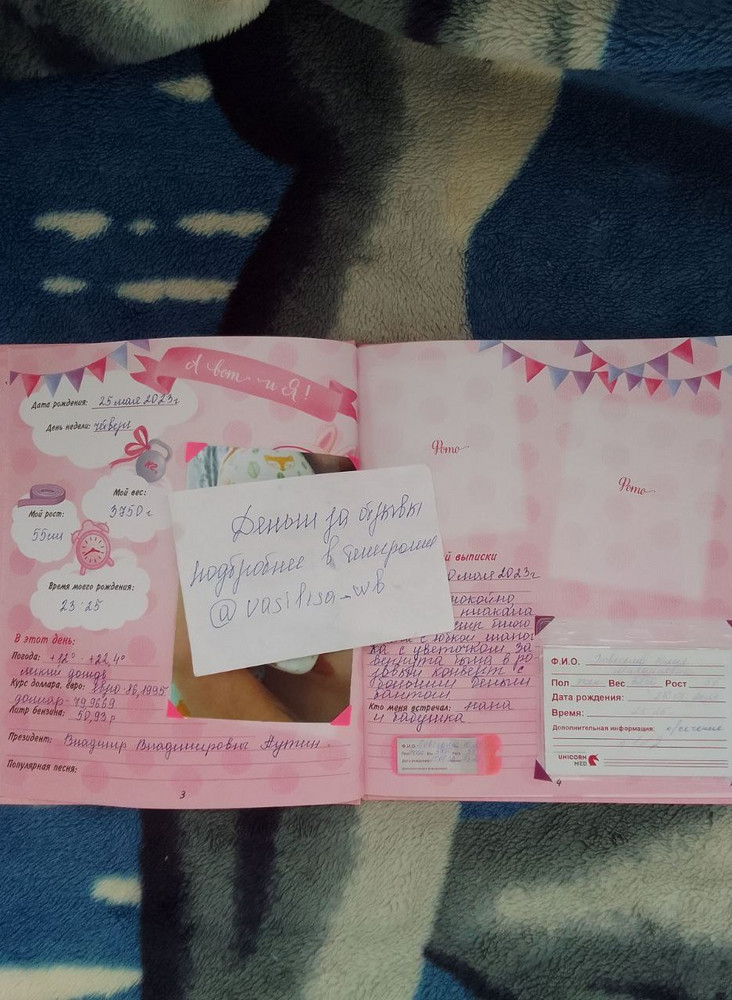


-----------

/content/LittleDataset/1/142148235.jpg
[2024/07/23 19:11:06] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/07/23 19:11:06] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.08613801002502441
[2024/07/23 19:11:06] ppocr DEBUG: rec_res num  : 35, elapsed : 0.08123207092285156

 За акие отзьв латят оеалыные деньги сагакл н 25 зооор шТ Ищи тeлeгy anteam. Wђ NGArAKU LIЕТ PADS PЕРМ FiхтlO ш ?Бim NAGARAKU Naigairku! SETTINGTLS EAINSEL IR ITIOf 5m ++ 5m 


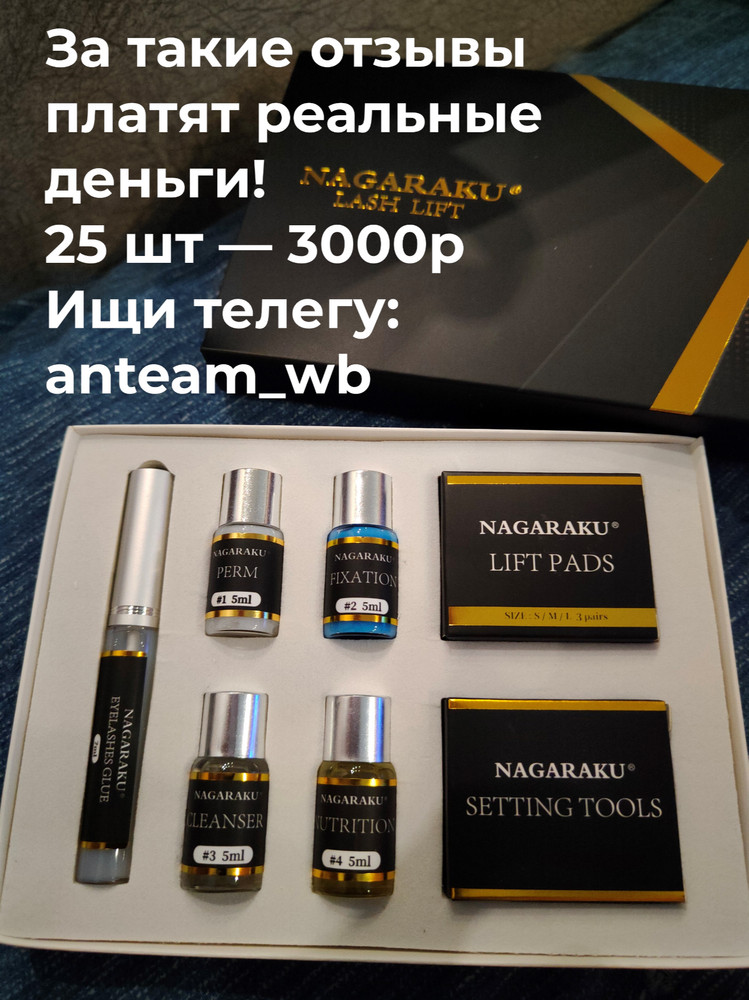


-----------

/content/LittleDataset/1/142214385.jpg
[2024/07/23 19:11:06] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/07/23 19:11:06] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.04898500442504883
[2024/07/23 19:11:06] ppocr DEBUG: rec_res num  : 12, elapsed : 0.03163337707519531

 За такие Oт3bIBb! лађяђ 25OOР за 25 т Ищи бOT. Otzovy-work. Wb, bot 


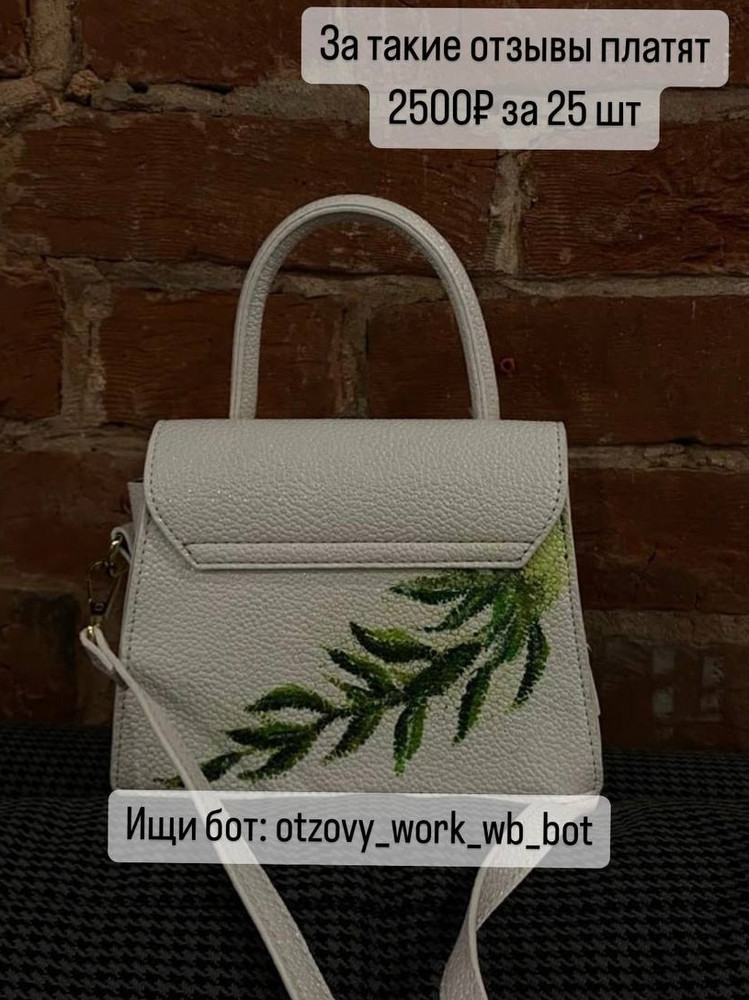


-----------

/content/LittleDataset/1/151619048.jpg
[2024/07/23 19:11:06] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/07/23 19:11:06] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08320784568786621
[2024/07/23 19:11:07] ppocr DEBUG: rec_res num  : 17, elapsed : 0.032510995864868164

 За такие от3ьBь Oт 25оор латят NATRAELOKN FASHIOn BROW MASCA бот ищи B телеге оtzоц esh bot 


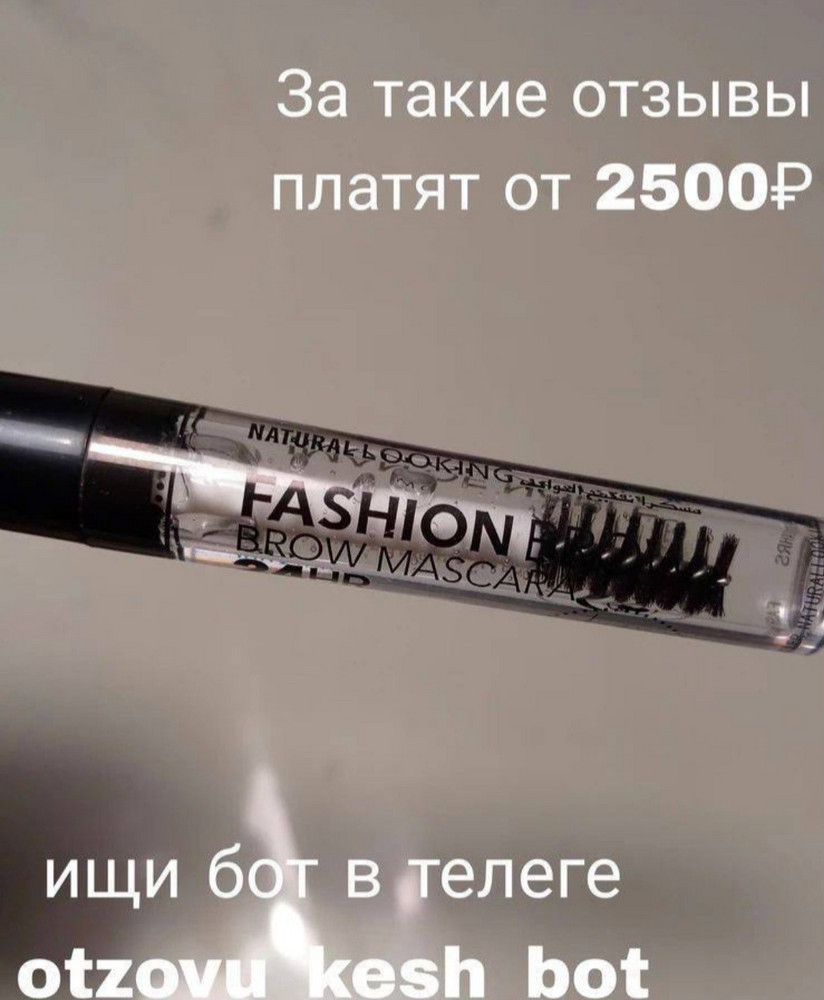


-----------

/content/LittleDataset/1/123307897.jpg
[2024/07/23 19:11:07] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/07/23 19:11:07] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.0692892074584961
[2024/07/23 19:11:07] ppocr DEBUG: rec_res num  : 18, elapsed : 0.045892953872680664

 олучайте хорошую Bзможнсть зарабатывать деньги за отзьв Ha Wildberries 3ooop- за зо оТзывов одробнее B тeлeграмм Aprincess- Signal 


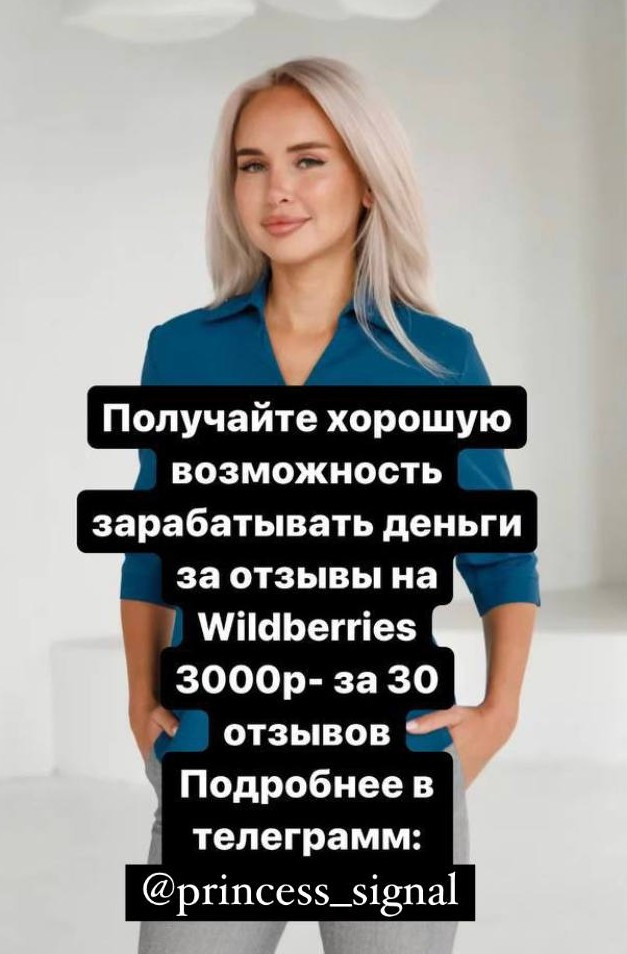


-----------

/content/LittleDataset/1/151637936.jpg
[2024/07/23 19:11:07] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/07/23 19:11:07] ppocr DEBUG: dt_boxes num : 51, elapsed : 0.09164905548095703
[2024/07/23 19:11:07] ppocr DEBUG: rec_res num  : 51, elapsed : 0.09283709526062012

 рши шие Ребятки Kому нужна подработка? Нужно делать рост скрины! 15 скринов 1оо зо скринов зоо о скринов бооо EEah. пежамкд оо скринов гооо Oт Bас нeет HИкакИ Bложений о ин иши Jo Hас B Teлeгpаммe. Oanast. Wђоzћ ножниц Wв zн 


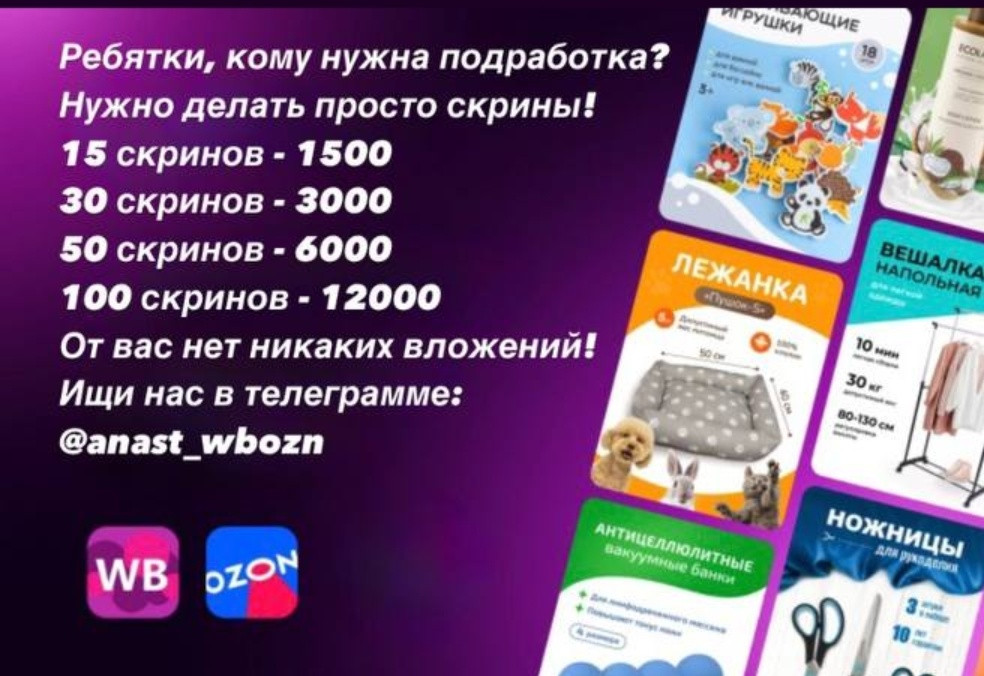


-----------



In [ ]:
from IPython.display import Image, display

for i in range(10):
  imgPath = dataPath_1+'/'+fraudImg[i]
  print(imgPath)
  print("\n",paddle_predict(imgPath))
  img = Image(filename=imgPath, width=300)
  display(img)
  print("\n-----------\n")

## Модель обработки текста

### Исправление текста

In [ ]:
!pip install errant --quiet
!pip install Levenshtein --quiet
!pip install transformers --quiet

In [ ]:
!git clone https://github.com/ai-forever/sage.git
!pip install /content/sage/.

In [ ]:
from sage.spelling_correction import AvailableCorrectors
from sage.spelling_correction import RuM2M100ModelForSpellingCorrection, T5ModelForSpellingCorruption

def text_corrector(text):
  corrector_small = T5ModelForSpellingCorruption.from_pretrained(AvailableCorrectors.sage_fredt5_distilled_95m.value) #sage - fredt5_distilled_95m

  #corrector_medium = RuM2M100ModelForSpellingCorrection.from_pretrained(AvailableCorrectors.sage_m2m100_1B.value) # sage_m2m100_1B
  #corrector_big = T5ModelForSpellingCorruption.from_pretrained(AvailableCorrectors.sage_mt5_large.value) #sage - fredt5_large
  #del corrector_big.model

  res = str(corrector_small.correct(text))
  res = res.translate(str.maketrans("", "", "[]'"))
  return res



In [ ]:
#del corrector_small.model
#del corrector_medium.model
#del corrector_big.model

In [ ]:
text_ru = "заподобные отзовы мышпиденыи 10 зызов -100р подйнепивт uыw_ыыlп"
print(text_corrector(text_ru))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/1 [00:00<?, ?it/s]

Заподобные отзывы: мышпидены, 10 отзывов - 100 р. поднепивут uaw_ыыlп.


### текстовый датасет

In [ ]:
!pip install transformers --quiet
!pip install datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.

In [ ]:
import os

In [ ]:
!wget -O fraudTextDataset.zip "https://www.dropbox.com/scl/fi/il79tnfe4hzfxsdbm54lb/fraudTextDataset.zip?rlkey=r1ycxa8acqvmeldzuw76299k4&st=yoseb6t2&dl=0"

if not os.path.exists('fraudTextDataset'):
    os.system('unzip fraudTextDataset.zip')

fraudTxtPath = "/content/fraudTextDataset/1"
NormTxtPath = "/content/fraudTextDataset/0"

--2024-08-08 13:36:53--  https://www.dropbox.com/scl/fi/il79tnfe4hzfxsdbm54lb/fraudTextDataset.zip?rlkey=r1ycxa8acqvmeldzuw76299k4&st=yoseb6t2&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3f72483602d34e9d5fab48e104.dl.dropboxusercontent.com/cd/0/inline/CYS2_DW5Eh4VMWA_23LMsGqGSsatx1he0WdsAjMZe3BX75R9mKZJ5yBn5CgimRpyWHOq9sZMO1XB37LQW7lwp_7Je2iYBT6EhOZUOTsHC5Akdh-pX_6JTVf7SFqH4MmiATO1EXKCoWtn44fz5-mB3d_l/file# [following]
--2024-08-08 13:36:54--  https://uc3f72483602d34e9d5fab48e104.dl.dropboxusercontent.com/cd/0/inline/CYS2_DW5Eh4VMWA_23LMsGqGSsatx1he0WdsAjMZe3BX75R9mKZJ5yBn5CgimRpyWHOq9sZMO1XB37LQW7lwp_7Je2iYBT6EhOZUOTsHC5Akdh-pX_6JTVf7SFqH4MmiATO1EXKCoWtn44fz5-mB3d_l/file
Resolving uc3f72483602d34e9d5fab48e104.dl.dropboxusercontent.com (uc3f72483602d34e9d5fab48e104.dl.dropboxusercontent.com

In [ ]:
fraudTxtNames = list(os.listdir(fraudTxtPath))
NormTxtNames = list(os.listdir(NormTxtPath))

In [ ]:
import pandas as pd

# Создаем пустой список для хранения данных
data = []

# Проходим по каждому файлу в списке
for file_name in fraudTxtNames:
    with open(fraudTxtPath+"/"+file_name, 'r', encoding='utf-8') as file:
        # Читаем строки из файла и добавляем их в список
        lines = file.readlines()
        # Убираем пробелы и символы новой строки
        lines = [line.strip() for line in lines]
        # Добавляем строки в общий список данных
        data.extend(lines)

# Создаем DataFrame из списка данных
dfFraudTxt = pd.DataFrame(data, columns=['text'])
dfFraudTxt['label'] = 1
# Выводим первые 5 строк DataFrame

data = []

# Проходим по каждому файлу в списке
for file_name in NormTxtNames:
    with open(NormTxtPath+"/"+file_name, 'r', encoding='utf-8') as file:
        # Читаем строки из файла и добавляем их в список
        lines = file.readlines()
        # Убираем пробелы и символы новой строки
        lines = [line.strip() for line in lines]
        # Добавляем строки в общий список данных
        data.extend(lines)

# Создаем DataFrame из списка данных
dfNormTxt = pd.DataFrame(data, columns=['text'])
dfNormTxt['label'] = 0

TextDf = pd.concat([dfFraudTxt, dfNormTxt], ignore_index=True)

TextDf.shape

(1100, 2)

In [ ]:
dfText = pd.read_csv('dfText.csv')

In [ ]:
TextDf = pd.concat([dfText, TextDf], ignore_index=True)
TextDf.shape

(3100, 3)

In [ ]:
TextDf['label'].value_counts(normalize = True)

label
1    0.5
0    0.5
Name: proportion, dtype: float64

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Разделение DataFrame на train и test
train_df, temp_df  = train_test_split(TextDf, test_size=0.3, random_state=42)
val_df, test_df   = train_test_split(TextDf, test_size=0.5, random_state=42)

train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

train_dataset = train_dataset.remove_columns(["__index_level_0__"])
val_dataset = val_dataset.remove_columns(["__index_level_0__"])
test_dataset = test_dataset.remove_columns(["__index_level_0__"])

print(train_dataset,test_dataset,val_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 2170
}) Dataset({
    features: ['text', 'label'],
    num_rows: 1550
}) Dataset({
    features: ['text', 'label'],
    num_rows: 1550
})


In [ ]:
dataset_dict = DatasetDict(train=train_dataset, validation = val_dataset, test=test_dataset)

# Выводим информацию о DatasetDict
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2170
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1550
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1550
    })
})


### Rubert обрабатывает текст

In [ ]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

tqdm.pandas()

device = torch.device('cuda')

In [ ]:
bert = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
train_text = train_df['text'].astype('str')
train_labels = train_df['label']
val_text = val_df['text'].astype('str')
val_labels = val_df['label']
test_text = test_df['text'].astype('str')
test_labels = test_df['label']

<Axes: >

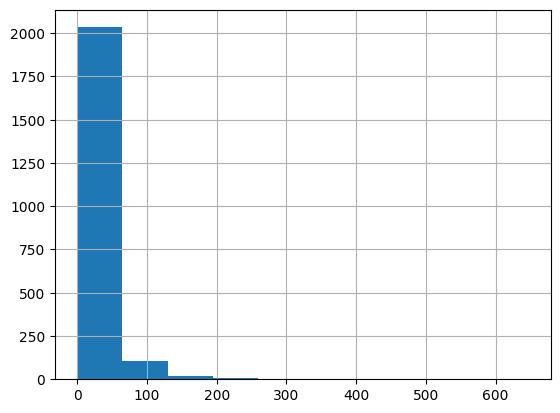

In [ ]:
seq_len = [len(str(i).split()) for i in train_text]
pd.Series(seq_len).hist(bins = 10)

In [ ]:
MAX_LENGHT = 10

In [ ]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.values,
    max_length = MAX_LENGHT,
    padding = 'max_length',
    truncation = True
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.values,
    max_length = MAX_LENGHT,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.values,
    max_length = MAX_LENGHT,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.values)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.values)

batch_size = 8


train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data =  TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
model = BERT_Arch(bert)

model = model.to(device)
from transformers import AdamW

optimizer = AdamW(model.parameters(),
               lr= 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print(class_weights)

weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)
cross_entropy = nn.CrossEntropyLoss()

[0.98546776 1.01496726]


In [ ]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

In [ ]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)\

    return avg_loss, total_preds

In [ ]:
best_valid_loss = float('inf')
epochs = 5
train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, _ = train()
    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')


 Epoch1 / 5


100%|██████████| 194/194 [00:01<00:00, 108.38it/s]



Training loss: 0.312
Validation loss: 0.249

 Epoch2 / 5


100%|██████████| 194/194 [00:01<00:00, 110.36it/s]



Training loss: 0.229
Validation loss: 0.181

 Epoch3 / 5


100%|██████████| 194/194 [00:01<00:00, 108.97it/s]



Training loss: 0.205
Validation loss: 0.173

 Epoch4 / 5


100%|██████████| 194/194 [00:01<00:00, 108.46it/s]



Training loss: 0.174
Validation loss: 0.115

 Epoch5 / 5


100%|██████████| 194/194 [00:01<00:00, 111.08it/s]


Training loss: 0.175
Validation loss: 0.116


In [ ]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

list_seq = np.array_split(test_seq, 50)
list_mask = np.array_split(test_mask, 50)


predictions = []
for num, elem in enumerate(list_seq):
    with torch.no_grad():
        preds = model(elem.to(device), list_mask[num].to(device))
        predictions.append(preds.detach().cpu().numpy())

In [ ]:
flat_preds = [item[1] for sublist in predictions for item in sublist]
flat_preds = (flat_preds - min(flat_preds)) / (max(flat_preds) - min(flat_preds))
test_df['confidence'] = flat_preds

In [ ]:
def predict(text, model, tokenizer, device, sentense_max_lenght = 10):
    # Токенизация входного текста
    tokens = tokenizer.encode_plus(
        text,
        max_length=sentense_max_lenght,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    test_seq = tokens['input_ids'].clone().detach()
    test_mask = tokens['attention_mask'].clone().detach()

    # Перенос тензоров на устройство
    input_ids = test_seq.to(device)
    attention_mask = test_mask.to(device)

    # Отключение градиентов
    with torch.no_grad():
        # Получение предсказаний
        output = model(input_ids, attention_mask)

        # Применение softmax для получения вероятностей
        probs = torch.softmax(output, dim=1)

        # Получение предсказанного класса
        predicted_class = torch.argmax(probs, dim=1).item()

    return predicted_class

In [ ]:
test_df['pred'] = test_df['confidence'].apply(lambda x: 1 if x>0.92 else 0)

print(classification_report(test_df['label'], test_df['pred']))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       769
           1       0.91      0.93      0.92       781

    accuracy                           0.92      1550
   macro avg       0.92      0.92      0.92      1550
weighted avg       0.92      0.92      0.92      1550



In [ ]:
test_df

text            img  label  \
718   prada мo  8 за nиde  аевv 1такие tы f хг merca...  156886682.jpg      1   
2953  Автомобильный держатель для телефона надежный,...            NaN      0   
1805  входящие ыlеацен шпьотыр desktal уатройства дд...  168521911.jpg      0   
1612  9сsбaб9toct wildberries zn nг 1    wм1 lмn  3 ...  165449844.jpg      0   
1190             шal 39 56 элэwuse xжs\nпi 66 col 3 xжs  149765705.jpg      0   
...                                                 ...            ...    ...   
1553  бета-глюкан guarchlbao immunity forte 30 copgu...  165498322.jpg      0   
1586                                             fl\nfl  167290296.jpg      0   
697   ребятки hv подроботка нужно делать просто скри...  154748262.jpg      1   
2590  Прекрасный органайзер для косметики, удобно хр...            NaN      0   
348   ребятки кому нужна подроботка нужно делать про...  160903388.jpg      1   

      confidence  pred  
718     0.997585     1  
2953    0.731829     0  
1805    0.886458     0  
1612    0.824673     0  
1190    0.810906     0  
...          ...   ...  
1553    0.682143     0  
1586    0.665624     0  
697     0.999893     1  
2590    0.406287     0  
348     0.999998     1  

[1550 rows x 5 columns]

In [ ]:
res = predict("тг канал @cool_tool",model,tokenizer,device )
res

1

In [ ]:
sound_alert()

NameError: name 'sound_alert' is not defined

# Решение

### easyocr

In [ ]:
!pip install python-bidi==0.4.2 --quiet
!pip install easyocr --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 33.7 MB/s eta 0:00:00


In [ ]:
#from IPython.display import Image, display
import re
import easyocr
import cv2
import numpy as np
from PIL import Image
import io


In [ ]:
# Функция для объединения строк
def merge_strings(s1, s2):
    merged = []
    for part1, part2 in zip(s1, s2):
        # Находим индекс первого английского символа или знака @
        match = re.search(r'[a-zA-Z@]', part1)
        if match:
            # Получаем индекс первого вхождения
            index = match.start()
            # Составляем новую строку: часть до английского символа + часть из второй строки
            new_part = part1[:index] + part2[index:]  # Заменяем только часть начиная с первого английского символа
            merged.append(new_part)
        else:
            merged.append(part1)  # Если английских символов нет, оставляем часть из первой строки
    return merged

def norm_string(s1):
    merged = []
    for part in s1:
          merged.append(part)
    return merged

In [ ]:
def clean_text(text):
    # Переводим текст в нижний регистр
    text = text.lower()

    # Заменяем знак ₽ на "р"
    text = text.replace("₽", "р")

    # Заменяем "o" и "о" на "0", если слева стоит цифра
    text = re.sub(r'(?<=\d)(o|о)', '0', text)

    # Удаляем все знаки препинания, кроме пробелов и тире
    text = re.sub(r'[^\w\s-]', '', text)

    return text

def remove_short_words(text):
  # Разделяем текст на слова
  words = text.split()

  # Фильтруем слова
  filtered_words = [
      word for word in words
      if len(word) >= 3 or re.search(r'\d', word)  # Сохраняем слово, если оно длиннее 2 символов или содержит цифры
  ]

  # Объединяем отфильтрованные слова обратно в строку
  return ' '.join(filtered_words)

In [ ]:
class TextRecognizer:
    def __init__(self, languages=["ru", "en"]):
        # Инициализация модели только один раз
        self.reader = easyocr.Reader(languages)

    def text_recognition(self, file_path):
        # Предобработка изображения
        img = imgPreproces(file_path)
        result_base = ""
        result_base += self.recognition(img) + "\n"
        result_base += self.recognition(img,spin=True)

        tmp = clean_text(result_base)
        return tmp

    def recognition(self,img, spin = False):
        if spin:
          spinList = [90,270]
        else: spinList = None

        # Чтение текста с изображения
        res = self.reader.readtext(
            img,
            decoder='wordbeamsearch',
            detail=0,
            paragraph=True,
            batch_size=64,
            rotation_info = spinList
        )
        result = norm_string(res)
        # Преобразуем результат в строку
        final_result = ' '.join(result)
        return final_result



In [ ]:
def imgPreproces(file_path):
    image = cv2.imread(file_path,0)
    return image

    average_brightness = int(np.mean(image))
    if (average_brightness > 110):
      invert = cv2.bitwise_not(image)
    else: invert = image

    brightnes = cv2.convertScaleAbs(invert, beta=60)

    _, im_bw = cv2.threshold(brightnes, 200, 230, cv2.THRESH_BINARY)

    return im_bw

### Исправление текста

In [ ]:
!pip install errant --quiet
!pip install Levenshtein --quiet
!pip install transformers --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.3/499.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 8.6 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/ai-forever/sage.git
!pip install /content/sage/. --quiet

In [ ]:
from sage.spelling_correction import AvailableCorrectors
from sage.spelling_correction import RuM2M100ModelForSpellingCorrection, T5ModelForSpellingCorruption

In [ ]:
def text_corrector(text):
  corrector_small = T5ModelForSpellingCorruption.from_pretrained(AvailableCorrectors.sage_fredt5_distilled_95m.value) #sage - fredt5_distilled_95m

  #corrector_medium = RuM2M100ModelForSpellingCorrection.from_pretrained(AvailableCorrectors.sage_m2m100_1B.value) # sage_m2m100_1B
  #corrector_big = T5ModelForSpellingCorruption.from_pretrained(AvailableCorrectors.sage_mt5_large.value) #sage - fredt5_large
  #del corrector_big.model

  res = str(corrector_small.correct(text))
  res = res.translate(str.maketrans("", "", "[]'"))
  res = clean_text(res)
  return res



In [ ]:
#del corrector_small.model
#del corrector_medium.model
#del corrector_big.model

In [ ]:
#text_ru = "заподобные отзовы мышпиденыи 10 зызов -100р подйнепивт uыw_ыыlп"
#corrected_text = text_corrector(text_ru)

### Rubert обрабатывает текст

In [ ]:
!wget -O saved_weights.pt "https://www.dropbox.com/scl/fi/srhc6ro4vxnysdn2z2mh4/saved_weights.pt?rlkey=faoxyxs2e9o26f14mf9to1k38&st=i6bkygr0&dl=0"

--2024-08-16 17:00:42--  https://www.dropbox.com/scl/fi/srhc6ro4vxnysdn2z2mh4/saved_weights.pt?rlkey=faoxyxs2e9o26f14mf9to1k38&st=i6bkygr0&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb17f7f60908d83c08d02ceba74.dl.dropboxusercontent.com/cd/0/inline/CYzFarrReOgjZYu-0VSLPX1JL-yCrlmTvo5yYiB_dNxx_vCUemXfvOG-2o7rLRrkbIY-Ab3vlsIIDDXG9nKXABl_Al5P3jJd0QJQepsyQrg40muIzn2OwWIAf2hzzOzqNxGKVzqMlevQIg8MZnOBRBMd/file# [following]
--2024-08-16 17:00:43--  https://ucb17f7f60908d83c08d02ceba74.dl.dropboxusercontent.com/cd/0/inline/CYzFarrReOgjZYu-0VSLPX1JL-yCrlmTvo5yYiB_dNxx_vCUemXfvOG-2o7rLRrkbIY-Ab3vlsIIDDXG9nKXABl_Al5P3jJd0QJQepsyQrg40muIzn2OwWIAf2hzzOzqNxGKVzqMlevQIg8MZnOBRBMd/file
Resolving ucb17f7f60908d83c08d02ceba74.dl.dropboxusercontent.com (ucb17f7f60908d83c08d02ceba74.dl.dropboxusercontent.com)...

In [ ]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn

import torch
import transformers

from transformers import BertTokenizer, AutoModel

tqdm.pandas()

device = torch.device('cuda')

In [ ]:
model_name = 'DeepPavlov/rubert-base-cased-sentence'

bert = AutoModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
path = 'saved_weights.pt'

model = BERT_Arch(bert)
model.load_state_dict(torch.load(path))
model = model.to(device)

In [ ]:
def predict(text, model, tokenizer, device, sentense_max_lenght = 10):
    # Токенизация входного текста
    tokens = tokenizer.encode_plus(
        text,
        max_length=sentense_max_lenght,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # Перенос тензоров на устройство
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)

    # Отключение градиентов
    with torch.no_grad():
        # Получение предсказаний
        output = model(input_ids, attention_mask)

        # Извлечение предсказаний
        logits = output#.logits

        # Применение softmax для получения вероятностей
        probs = torch.softmax(logits, dim=1)

        # Получение предсказанного класса
        predicted_class = torch.argmax(probs, dim=1).item()

    return predicted_class

In [ ]:
res = predict("деньги за работу",model,tokenizer,device)
res

1

# Тесты

### Датасет

In [ ]:
!wget -O test.zip "https://www.dropbox.com/scl/fi/y7dzqge2zk6cvhvll4vbo/test.zip?rlkey=p0uo77xap2g209evvstlbsudf&st=oprp0gfz&dl=0"
!unzip test.zip

--2024-08-16 17:03:04--  https://www.dropbox.com/scl/fi/y7dzqge2zk6cvhvll4vbo/test.zip?rlkey=p0uo77xap2g209evvstlbsudf&st=oprp0gfz&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2fecbcbbf2cd4d3a0f8e912396.dl.dropboxusercontent.com/cd/0/inline/CYxoYhfRcpQMYlB9IqsfQN-9lblN_a6alWDSCOxCz1VOGDcVmfx84fWi6LeThD9HYhuoDQF8nuKibXVFKRE5B69oACQ8XDzQrBpb7oPrczpTJCDBfLt_Adc2z6LCwGF_EKAho4_EdLbBDBoeOIw-obnu/file# [following]
--2024-08-16 17:03:05--  https://uc2fecbcbbf2cd4d3a0f8e912396.dl.dropboxusercontent.com/cd/0/inline/CYxoYhfRcpQMYlB9IqsfQN-9lblN_a6alWDSCOxCz1VOGDcVmfx84fWi6LeThD9HYhuoDQF8nuKibXVFKRE5B69oACQ8XDzQrBpb7oPrczpTJCDBfLt_Adc2z6LCwGF_EKAho4_EdLbBDBoeOIw-obnu/file
Resolving uc2fecbcbbf2cd4d3a0f8e912396.dl.dropboxusercontent.com (uc2fecbcbbf2cd4d3a0f8e912396.dl.dropboxusercontent.com)... 162.1

In [ ]:
dataPathTest_1 ='/content/test/1'
dataPathTest_0 = '/content/test/0'

In [ ]:
import random
import os

fraudImgTest = list(os.listdir(dataPathTest_1))
okImgTest = list(os.listdir(dataPathTest_0))

random.shuffle(fraudImgTest)
random.shuffle(okImgTest)

In [ ]:
fraudImgPathTest = [dataPathTest_1 + '/' + img for img in fraudImgTest]
okImgPathTest = [dataPathTest_0  + '/' + img for img in okImgTest]

In [ ]:
import pandas as pd

# Создаем DataFrame для фрод-изображений
fraud_data_t = pd.DataFrame({
    'name': fraudImgPathTest,
    'fraud': [1] * len(fraudImgPathTest)  # Все значения fraud равны 1
})

# Создаем DataFrame для нормальных изображений
ok_data_t = pd.DataFrame({
    'name': okImgPathTest,
    'fraud': [0] * len(okImgPathTest)      # Все значения fraud равны 0
})

# Объединяем два DataFrame
dataDf_test = pd.concat([fraud_data_t, ok_data_t], ignore_index=True)
dataDf_test = dataDf_test.sample(frac=1).reset_index(drop=True)
dataDf_test.head(5)

name  fraud
0  /content/test/0/img (11).jpg      0
1   /content/test/1/img (1).jpg      1
2   /content/test/0/img (6).jpg      0
3   /content/test/1/img (4).jpg      1
4   /content/test/1/img (6).jpg      1

### Итоговая функция обработки

In [ ]:
recognizer = TextRecognizer()

In [ ]:
def fraud_img_detection(file_path,recognizer = recognizer):
  text_from_image = recognizer.text_recognition(file_path)
  #print(text_from_image)
  #corrected_text = text_corrector(text_from_image)
  #print(corrected_text)
  res = predict(text_from_image,model,tokenizer,device)
  return res

In [ ]:
import pandas as pd
import random
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from tqdm import tqdm

# Выделение тестовой выборки (1000 случайных элементов)
#test_sample = dataDf_test.sample(n=500, random_state=777)
test_sample = dataDf_test

tqdm.pandas()
# Предсказания модели
test_sample['predicted_label'] = test_sample['name'].progress_apply(fraud_img_detection)

100%|██████████| 21/21 [00:42<00:00,  2.02s/it]


In [ ]:
#@title тесты проводятся на сильно усложнённом датасете, результаты на реальных примерах фрода сильно выше
from sklearn.metrics import precision_score, recall_score, roc_auc_score
# Расчет метрик precision и recall
precision = precision_score(test_sample['fraud'], test_sample['predicted_label'])
recall = recall_score(test_sample['fraud'], test_sample['predicted_label'])
roc_auc = roc_auc_score(test_sample['fraud'], test_sample['predicted_label'])

# Вывод результатов
print(f'\nPrecision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'roc auc: {roc_auc:.2f}')


Precision: 0.50
Recall: 0.67
roc auc: 0.70


In [ ]:
mismatched_rows = test_sample[test_sample['fraud'] != test_sample['predicted_label']]
mismatched_rows['text'] = mismatched_rows['name'].progress_apply(recognizer.text_recognition)
# Вывод результата
mismatched_rows

100%|██████████| 6/6 [00:03<00:00,  1.57it/s]
<ipython-input-33-19695144e27b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatched_rows['text'] = mismatched_rows['name'].progress_apply(recognizer.text_recognition)


name  fraud  predicted_label  \
1    /content/test/1/img (1).jpg      1                0   
4    /content/test/1/img (6).jpg      1                0   
6    /content/test/0/img (5).jpg      0                1   
14   /content/test/0/img (2).jpg      0                1   
15  /content/test/0/img (12).jpg      0                1   
18   /content/test/0/img (4).jpg      0                1   

                                                 text  
1                    i1  7 е f\nсэоbвы  rich плачу тг  
4   вkуcы мира чай черный cool_tea\n3 мира чай чер...  
6   хочушнтв шнб превшпщии ешшиеынеш4d бы тл нейчн...  
14  юаюиедлишныеюогтм аверно неубираешья домп ше ш...  
15  nutri protein 100 sein slim cocktail shake вiо...  
18       скдчать картинку webp\nскдчать картинку webp



---



# Мысли по решению

OCR подход к классификации фрода безусловноя является наиболее стабильным и интерпретируемым. Кроме того он может быть значительно упрощён (OCR + banlist языковой модели) или напротив маштабирован как в данном случае.

Главной проблемой такого подхода однако является низкая скорость работы и недообученность большинства ocr моделей на русском языке. Таким образом OCR подход хорошо подойбёт для решений которые требуют высокой степени ответственности модели благодаря возможности объяснить